In [4]:
# Set up
%pylab inline
%run params.py

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True

# Import libraries
import os
import pandas as pd
import scipy.stats
import seaborn as sns

############ Set up paths #############
SAVEPLOT = True
PREFIX = "eSTR-Nuc"
FIGPREFIX = "Figure5"
DATADIR = os.path.join(BASEDATADIR, PREFIX)
RESULTSDIR = os.path.join(BASERESULTSDIR, PREFIX)

############ Load data #############
estrs = pd.read_csv(os.path.join(BASERESULTSDIR, "eSTR-calling","SuppTable_ALLCAUSAL.csv"))
geneannot = pd.read_csv(GENEANNOT)
geneannot["gene"] = geneannot["gene.id"].apply(lambda x: x.split(".")[0])
estrs = pd.merge(estrs, geneannot[["gene", "gene.strand"]], on=["gene"])

causal = estrs[estrs["score"]>=MIN_CAUSAL_SCORE]

Populating the interactive namespace from numpy and matplotlib


In [12]:
# How many causal are polyA/T?
x=(causal[causal["motif"].apply(lambda x: x in ["A","T"])].shape[0])
y=(causal.shape[0])
print(x)
print(y)
print(x/y*1.0)

# Bias overall in effect direction
b = list(causal[causal["motif"].apply(lambda x: x in ["A","T"])]["beta"].apply(lambda x: int(x>0)))
print(np.mean(b))
print(scipy.stats.binom_test(sum(b), len(b)))

1337
3474
0.38485895221646516
0.5078534031413613
0.5844151039978582


In [17]:
# see https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5240917/

# Figure 3: Effect size direction poly(dA/dT)

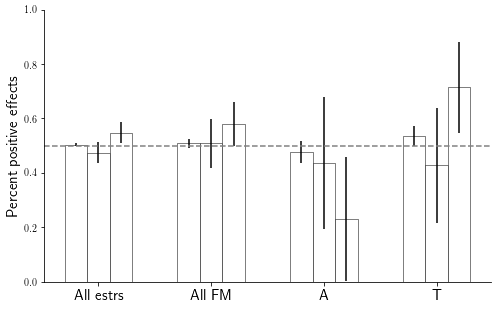

In [18]:
# Effect size bias for homopolymers

labels = []
colors = []
ecolors = []
alphas = []
dirs = []
stderrs = []
nums = []
xvals = []
pvals = []

w = 0.2
udist = 3000
ddist = 3000
tss_bins = [(-10000000, 10000000), (-1*udist, 0), (0, ddist)]
#tss_bins = [(-100000, -50000), (-50000, -10000), (-10000,-3000), (-3000, 0), (0, 3000), (3000,10000), (10000,50000), (50000, 100000)]
binlabels = ["ALL", "promoter", "downstream"]
bincolors = [ "white", "darkgray", "lightgray"]
binalphas = [1, 1, 1]
#binalphas = [1]*len(tss_bins)

def IsARich(x):
    return "A" in x #x.count("A")*1.0/len(x)>0.6

def IsTRich(x):
    return "T" in x # x.count("T")*1.0/len(x)>0.6


polyA = causal[causal["motif"]=="A"]
polyT = causal[causal["motif"]=="T"]
polyAC = causal[(causal["motif"]=="AC")]
polyGT = causal[(causal["motif"]=="GT")]
polyAG = causal[(causal["motif"]=="AG")]
polyCT = causal[(causal["motif"]=="CT")]
polyAT = causal[(causal["motif"]=="AT")]
Arich = causal[(causal["motif"].apply(IsARich))]
Trich = causal[(causal["motif"].apply(IsTRich))]

dfs = [ estrs, causal, polyA, polyT]
classcolors = ["white"]*40
dflabels = ["All estrs", "All FM", "A", "T", ]

ind = 0
for df in dfs:
    dflabel = dflabels[ind]
    for tbin in tss_bins:
        l = "tmp"#binlabels[tss_bins.index(tbin)]
        df_bin = df[(df["dist.tss"]>=tbin[0]) & (df["dist.tss"]<tbin[1])]
        perc = np.mean(df_bin["beta"]>0)
        dirs.append(perc)
        if perc < 1:
            stderrs.append(1.96*np.sqrt(perc*(1-perc)/df_bin.shape[0]))
        elif df_bin.shape[0] == 0: stderrs.append(0)
        else:
            stderrs.append(3/df_bin.shape[0])
        nums.append(df_bin.shape[0])
        pvals.append(scipy.stats.binom_test(perc*df_bin.shape[0], df_bin.shape[0]))
    colors.extend([classcolors[ind]]*len(tss_bins))
    alphas.extend(binalphas)
    ind += 1
    xvals.extend([ind+w*i for i in range(len(tss_bins))])
    labels.append(dflabel)
#print(len(alphas))
#print(len(colors))
rgba_colors = np.zeros((len(xvals), 4))
for i in range(len(colors)):
    rgba_colors[i, 0:3] = matplotlib.colors.to_rgba(colors[i])[0:3]
rgba_colors[:, 3] = alphas

fig = plt.figure()
fig.set_size_inches((8, 5))
ax = fig.add_subplot(111)
ax.bar(xvals, dirs, color=rgba_colors, edgecolor="black", linewidth=0.5, yerr=stderrs, ecolor="black",  width=w)
ax.axhline(y=0.5, linestyle="dashed", color="gray")
ax.set_ylim(bottom=0, top=1);
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
ax.set_xticks([xvals[i] for i in range(len(xvals)) if i%3 == 1])
ax.set_xticklabels(labels, size=15);
ax.set_ylabel("Percent positive effects", size=15)
fig.savefig(os.path.join(RESULTSDIR, "%s_ATDirection.pdf"%FIGPREFIX))

In [19]:
print("polyT")
print(nums[9:12])
print(dirs[9:12])
print(pvals[9:12])

print("polyA")
print(nums[6:9])
print(dirs[6:9])
print(pvals[6:9])

print("all causal")
print(nums[3:6])
print(dirs[3:6])
print(pvals[3:6])

print("all strs")
print(nums[0:3])
print(dirs[0:3])
print(pvals[0:3])

polyT
[710, 21, 28]
[0.5352112676056338, 0.42857142857142855, 0.7142857142857143]
[0.07767878414059755, 0.6636238098144525, 0.035698138177394874]
polyA
[627, 16, 13]
[0.4768740031897927, 0.4375, 0.23076923076923078]
[0.26346056425865827, 0.8036193847656252, 0.09228515625000003]
all causal
[3474, 118, 140]
[0.5086355785837651, 0.5084745762711864, 0.5785714285714286]
[0.33350752887740354, 0.9267042229477828, 0.07555082875265655]
all strs
[25561, 665, 630]
[0.5034623058565784, 0.47368421052631576, 0.5476190476190477]
[0.2709664693644683, 0.1873078067596973, 0.018671398852210613]


# Figure 3: poly(dA/dT) distribution around TSS

In [20]:
geneannot = pd.read_csv(GENEANNOT)
geneannot["gene"] = geneannot["gene.id"]
hipmotif = pd.read_csv(HIPREF, sep="\t", names=["chrom","str.start","str.end","period","motif_pos","motif_neg"])

all_str_genes = pd.read_csv(os.path.join(BASEDATADIR, "eSTR-enrich", "all_analyzed_estrs.tab"), sep="\t", names=["chrom","str.start","gene"])
all_str_genes = pd.merge(all_str_genes, geneannot[["gene","gene.start","gene.stop","gene.strand"]], on=["gene"])
all_str_genes = pd.merge(all_str_genes, hipmotif[["chrom","str.start","motif_pos","motif_neg"]], on=["chrom","str.start"])
all_str_genes["dist.tss"] = all_str_genes.apply(lambda x: (x["str.start"]-x["gene.start"]) if x["gene.strand"]=="+" else (x["gene.stop"]-x["str.start"]), 1)
all_str_genes["dist.tes"] = all_str_genes.apply(lambda x: (x["str.start"]-x["gene.start"]) if x["gene.strand"]=="-" else (x["gene.stop"]-x["str.start"]), 1)
all_str_genes["motif"] = all_str_genes.apply(lambda x: x["motif_pos"] if x["gene.strand"]=="+" else x["motif_neg"], 1)
all_str_genes["gene"] = all_str_genes["gene"].apply(lambda x: x.split(".")[0])
all_str_genes["str.start"] = all_str_genes["str.start"]+1

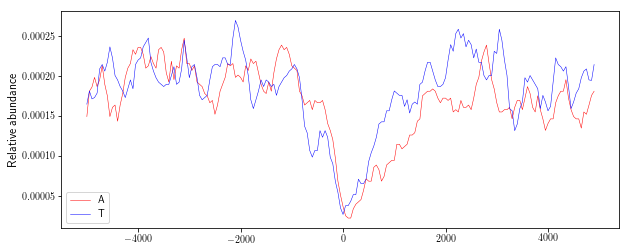

In [21]:
default_bins = np.arange(-50000, 50000, 1000)

def ProcessData(all_str_genes, estrs, causal, col, bins=default_bins, useabs=False):
    #keys = ["ALL","AC","GT","CG","AT","AG","CT","A","T"]
    all_motifs = set(all_str_genes["motif"])
    othermotifs = {
        "A": ["A"],
        "T": ["T"],
        "ALL": all_motifs,
    }
    keys = othermotifs.keys()
    num = {}
    p = {}
    p_causal = {}
    
    num_total = all_str_genes[["chrom","str.start"]].drop_duplicates().shape[0]
    num_estrs = estrs[["chrom","str.start"]].drop_duplicates().shape[0]
    num_causal = causal[["chrom","str.start"]].drop_duplicates().shape[0]
    p_avg = num_estrs*1.0/num_total
    p_causal_avg = num_causal*1.0/num_total
    
    # Get bindata
    for key in keys:
        num[key] = []
        p[key] = []
        p_causal[key] = []
        
        all_motif_data = all_str_genes[all_str_genes["motif"].apply(lambda x: x in othermotifs[key], 1)].copy()
        
        for i in range(len(bins)-1):
            lb = bins[i]
            ub = bins[i+1]
            if not useabs:
                x_all = all_motif_data[(all_motif_data[col]>=lb) & (all_motif_data[col]<ub)][["chrom","str.start"]].drop_duplicates().shape[0]
            else:
                nlb = abs(lb)
                nub = abs(ub)
                if nub<nlb:
                    nlb = abs(ub)
                    nub = abs(lb)
                x_all = all_motif_data[(all_motif_data[col].apply(abs)>=nlb) & (all_motif_data[col].apply(abs)<nub)][["chrom","str.start"]].drop_duplicates().shape[0]
            if x_all == 0:
                num[key].append(0)
            else:
                num[key].append(x_all*1.0/all_motif_data.shape[0])
    return num, p, p_causal, p_avg, p_causal_avg

def Smooth(x, buf=2, avg=None, norm=False):
    if avg is not None:
        x = [item*1.0/avg for item in x]
    if norm:
        m = np.mean(x)
        x = [item*1.0/m for item in x]
    newx = []
    for i in range(len(x)):
        l = max([0, i-buf])
        u = min([len(x), i+buf])
        newx.append(np.mean(x[l:u]))
    return newx

def PlotPosition(num, p, p_causal, p_avg, pcausal_avg, bins=default_bins, buf=2, col=None, RESULTSDIR=None):
    colors = {
    "A": ("red", "solid"),
    "T": ("blue", "solid"),
    "ALL": ("black", "solid")
    }
    size = ((10, 4))
    usekeys = colors.keys()
    
    fig = plt.figure()
    fig.set_size_inches(size)
    ax = fig.add_subplot(111)
    keys = ["A", "T"]
    for key in keys:
        if key == "ALL": w = 1.5
        else: w = 0.5
        ax.plot(bins[:-1], (Smooth(num[key], buf=buf)), color=colors[key][0], linestyle=colors[key][1], linewidth=w, label=key)
    ax.set_ylabel("Relative abundance", size=12)
    ax.legend(loc="lower left")
    if RESULTSDIR is not None: fig.savefig(os.path.join(RESULTSDIR, "Figure5_%s_num.pdf"%col))
    
#bins = np.arange(-5000, 5000, 50)
#num, p, p_causal, p_avg, p_causal_avg = ProcessData(all_str_genes2, estrs, causal, "dist.tss", bins=bins)
#PlotPosition(num, p, p_causal, p_avg, p_causal_avg, bins=bins, buf=3, col="dist.tss", RESULTSDIR=RESULTSDIR)

bins = np.arange(-5000, 5000, 50)
num, p, p_causal, p_avg, p_causal_avg = ProcessData(all_str_genes, estrs, causal, "dist.tss", bins=bins)
PlotPosition(num, p, p_causal, p_avg, p_causal_avg, bins=bins, buf=3, col="dist.tss", RESULTSDIR=RESULTSDIR)

In [22]:
# Heatmaps for nucleosomes

In [5]:
import seaborn as sns
from sklearn.cluster import KMeans
bins = np.arange(-500, 501, 5)
dnasecols = ["dnase-%s"%i for i in bins]
nuccols = ["nuc-%s"%i for i in bins]
cols = ["Gene"] + dnasecols + nuccols

period=1
df = pd.read_csv("/storage/mgymrek/gtex/homer-plots/taghist-dnase-all_causal_%s-wig-ghist.txt"%period, sep="\t")
df_ctrl = pd.read_csv("/storage/mgymrek/gtex/homer-plots/taghist-dnase-all_strs_%s-wig-ghist.txt"%period, sep="\t")
df.columns = cols
df_ctrl.columns = cols

df["dnase.sum"] = df[dnasecols].apply(sum, 1)
df["nuc.sum"] = df[nuccols].apply(sum, 1)
df_ctrl["dnase.sum"] = df_ctrl[dnasecols].apply(sum, 1)

means_dnase = df[dnasecols].apply(np.mean)
means_nuc = df[nuccols].apply(np.mean)
means_dnase_ctrl = df_ctrl[dnasecols].apply(np.mean)
means_nuc_ctrl = df_ctrl[nuccols].apply(np.mean)

# plot dnase/nuc signal aggregate
nucbins = [-147*3, -147*2, -147, 0, 147, 147*2, 147*3]

In [6]:
scipy.stats.ks_2samp(df["dnase.sum"], df_ctrl["dnase.sum"])

Ks_2sampResult(statistic=0.08016322297936129, pvalue=4.472752866373653e-08)

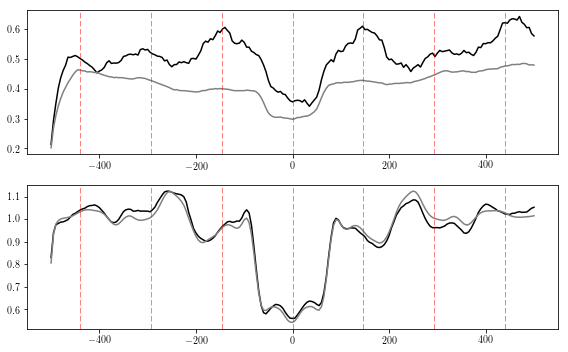

In [24]:
fig = plt.figure()
fig.set_size_inches((8,5))
ax = fig.add_subplot(211)


ax.plot(bins, means_dnase, color="black")
ax.plot(bins, means_dnase_ctrl, color="gray")

for nb in nucbins: ax.axvline(nb, color="red", linewidth=0.5, linestyle="dashed")
ax = fig.add_subplot(212)
ax.plot(bins, means_nuc, color="black")
ax.plot(bins, means_nuc_ctrl, color="gray")

for nb in nucbins: ax.axvline(nb, color="red", linewidth=0.5, linestyle="dashed")
fig.tight_layout()

fig.savefig(os.path.join(RESULTSDIR, "%s_DnaseMnaseProfile.pdf"%FIGPREFIX))

In [108]:
df = df[df["dnase.sum"]>0]
# Normalize each row to have same mean
for col in dnasecols:
    normvals = []
    for i in range(df.shape[0]):
        normvals.append(df[col].values[i]*1.0/df["dnase.sum"].values[i])
    df[col] = normvals
for col in nuccols:
    normvals = []
    for i in range(df.shape[0]):
        normvals.append(df[col].values[i]*1.0/df["nuc.sum"].values[i])
    df[col] = normvals

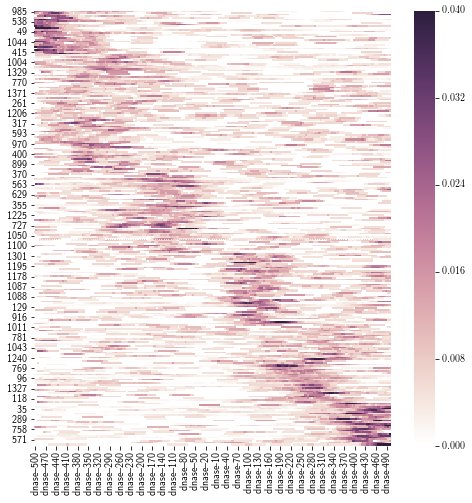

In [112]:
# Plot heatmap
df = df[df["dnase.sum"]>50]

num_clusters = 6
clusters = KMeans(num_clusters)
clusters.fit(df[dnasecols])
df["K"] = clusters.labels_

# reorder clusters such that signal goes left to right

k_to_max_bin = {}
for k in range(num_clusters):
    d = df[df["K"]==k][dnasecols]
    colmeans = list(d.apply(np.mean))
    k_to_max_bin[k] = colmeans.index(max(colmeans))

df["K_maxbin"] = df.apply(lambda x: k_to_max_bin[x["K"]], 1)
df = df.sort_values("K_maxbin")
    
cmap = cmap = sns.cubehelix_palette(light=1, as_cmap=True) #sns.light_palette("black")
fig = plt.figure()
fig.set_size_inches((8,8))
ax = fig.add_subplot(111)
sns.heatmap((df[dnasecols]), ax=ax, vmin=0, vmax=0.04, cmap=cmap)
fig.savefig(os.path.join(RESULTSDIR, "%s_DnaseHM.pdf"%FIGPREFIX))

In [27]:
# Characterize clusters
# direction, length, dist.tss, beta

,K,beta,dir,dir.p,dist.tss,lens,strand,strand.p
0,2,0.300323,0.567901,0.266412,47175.506173,14.370370,0.469136,0.656992
1,5,0.324578,0.543046,0.328809,48173.476821,14.887417,0.456954,0.328809
2,0,0.323749,0.550388,0.290688,56905.651163,14.658915,0.488372,0.860311
3,1,0.317319,0.555556,0.246706,48657.753968,14.420635,0.436508,0.181224
4,3,0.332321,0.524823,0.613513,40567.056738,16.276596,0.460993,0.399787
5,4,0.339669,0.493976,1.000000,57059.012048,15.349398,0.397590,0.078420


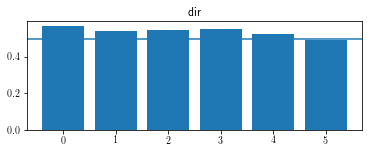

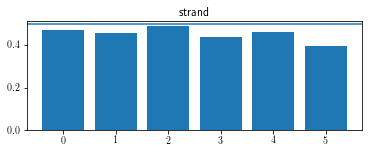

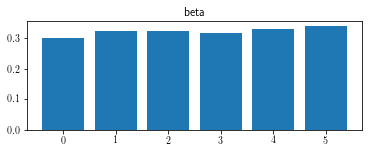

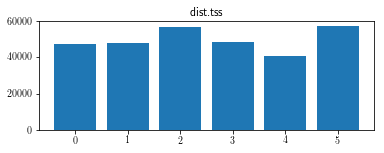

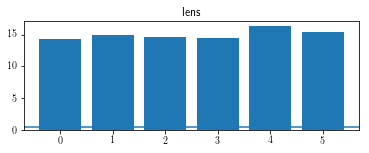

In [28]:
cdata = df[["Gene", "K"]].copy()
cdata["str.start"] = cdata["Gene"].apply(lambda x: int(x.split(":")[1]))
cdata = pd.merge(causal, cdata, on=["str.start"])
cdata["len"] = cdata["str.end"]-cdata["str.start"]+1

clusters = []
dirs = []
dirps = []
betas = []
dists = []
strands = []
strandps = []
lens = []

for k in [2,5,0,1, 3,4]: # range(num_clusters):
    x = cdata[cdata["K"]==k].copy()
    clusters.append(k)
    d = np.array((x["beta"]>0).apply(int))
    dirs.append(np.mean(d))
    dirps.append(scipy.stats.binom_test(sum(d), len(d)))
    betas.append(np.mean(x["beta"].apply(abs)))
    dists.append(np.mean(x["dist.tss"].apply(abs)))
    s = np.array((x["motif"]=="A").apply(int))
    strands.append(np.mean(s))
    strandps.append(scipy.stats.binom_test(sum(s), len(s)))
    lens.append(np.mean(x["len"]))
#    print("%s:%s:%s:%s:%s"%(k, k_to_max_bin[k], np.mean(x["beta"]>0), np.mean(x["beta"].apply(abs)), np.mean(x["dist.tss"].apply(abs))))

d = pd.DataFrame({"K": clusters, \
             "dir": dirs, \
             "dir.p": dirps, \
             "beta": betas, \
             "dist.tss": dists, \
             "strand": strands, \
             "strand.p": strandps, \
                 "lens": lens})
for col in ["dir","strand", "beta", "dist.tss","lens"]:
    fig = plt.figure()
    fig.set_size_inches((6, 2))
    ax = fig.add_subplot(111)
    ax.bar(range(d.shape[0]), d[col])
    if col not in [ "dist.tss","beta"]: ax.axhline(y=0.5)
    ax.set_title(col)
d

In [38]:
causal = estrs[estrs["score"]>=MIN_CAUSAL_SCORE]
dnaseI = pd.read_csv(os.path.join(BASEDATADIR, "annotations", "dnasehs_nearestSTR.bed"), sep="\t",
                 names=["chrom","str.start", "x","dist.dnase"])
dnaseI["str.start"] = dnaseI["str.start"]+1
causal = pd.merge(causal, dnaseI[["chrom","str.start","dist.dnase"]], on=["chrom","str.start"])

In [51]:
nucdata[0]

,beta,beta.err,dir,dir.err,dir.p,dist.dnase,dist.dnase.err,dist.tss,len,len.err,num,strand,strand.err,strand.p
0,0.298132,0.052835,0.424242,0.086034,0.486850,7167.454545,1399.872235,95470.121212,15.484848,1.291436,33,0.606061,0.085058,0.296206
1,0.285998,0.059391,0.480000,0.099920,1.000000,8109.920000,3277.507430,84370.600000,14.240000,0.900276,25,0.600000,0.097980,0.424356
2,0.284712,0.045413,0.439024,0.077504,0.532709,4889.341463,793.182056,74968.170732,14.536585,0.886207,41,0.536585,0.077878,0.755229
3,0.302047,0.051390,0.432432,0.081445,0.511376,6544.405405,1833.156073,64737.621622,14.972973,1.145057,37,0.486486,0.082169,1.000000
4,0.307889,0.053453,0.428571,0.083649,0.499560,6930.485714,1422.107349,54508.828571,15.257143,1.109766,35,0.571429,0.083649,0.499560
5,0.315356,0.053978,0.500000,0.081111,1.000000,4756.973684,869.010620,44088.973684,14.078947,0.715268,38,0.421053,0.080093,0.417692
6,0.301060,0.056380,0.566667,0.090472,0.584665,6242.166667,1166.454222,35068.233333,14.400000,0.877623,30,0.500000,0.091287,1.000000
7,0.312110,0.043838,0.454545,0.067141,0.590053,4853.309091,768.957391,24079.109091,15.636364,0.896039,55,0.527273,0.067320,0.787706
8,0.334154,0.039398,0.474359,0.056539,0.734342,4489.102564,476.464089,14651.000000,14.487179,0.621165,78,0.474359,0.056539,0.734342
9,0.333365,0.032755,0.445455,0.047389,0.294234,2900.127273,247.095491,4794.900000,16.063636,0.714811,110,0.481818,0.047642,0.775003


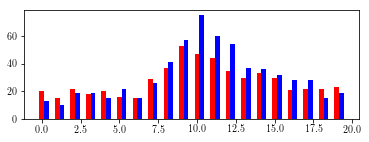

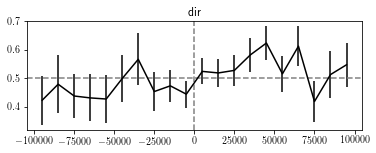

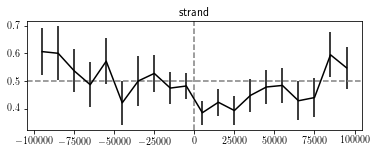

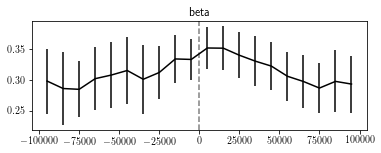

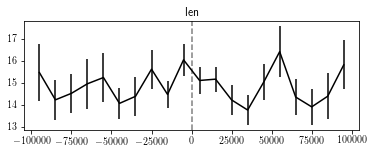

In [113]:

w = 10000
distbins = np.arange(-100000, 100000+w, w)
usecol = "dist.tss"

#w = 100
#distbins = np.arange(-1000, 1000+w, w)
#usecol = "dist.dnase"

nucdata = []
causal["len"] = causal["str.end"]-causal["str.start"]+1

cdata = df[["Gene", "K"]].copy()
cdata["str.start"] = cdata["Gene"].apply(lambda x: int(x.split(":")[1]))
cdata = pd.merge(causal, cdata, on=["str.start"])[["chrom","str.start","dist.tss","gene","beta","motif","len","dist.dnase"]].drop_duplicates()

for xx in [causal[causal["motif"].apply(lambda x: x in ["A"])], causal[causal["motif"].apply(lambda x: x in ["T"])], causal[causal["motif"].apply(lambda x: x in ["A","T"])]]:
    dirs = []
    dirps = []
    direrrs = []
    betas = []
    betaerrs = []
    dists = []
    strands = []
    strandps = []
    stranderrs = []
    lens = []
    lenerrs = []
    dnase = []
    dnaseerrs = []
    nums = []

    for d in range(len(distbins)-1):
        lb = distbins[d]
        ub = distbins[d+1]
        x = xx[(xx[usecol]>=lb) & (xx[usecol]<ub)].copy()
        dird = np.array((x["beta"]>0).apply(int))
        dirs.append(np.mean(dird))
        dirps.append(scipy.stats.binom_test(sum(dird), len(dird)))
        direrrs.append(np.sqrt(np.var(dird)/len(dird)))
        betas.append(np.mean(x["beta"].apply(abs)))
        betaerrs.append(np.sqrt(np.var(x["beta"])/x.shape[0]))
        dists.append(np.mean(x["dist.tss"].apply(abs)))
        s = np.array((x["motif"]=="A").apply(int))
        strands.append(np.mean(s))
        strandps.append(scipy.stats.binom_test(sum(s), len(s)))
        stranderrs.append(np.sqrt(np.var(s)/len(s)))
        lens.append(np.mean(x["len"]))
        lenerrs.append(np.sqrt(np.var(x["len"])/x.shape[0]))
        #dnase.append(np.mean(x["dist.dnase"].apply(abs)))
        #dnaseerrs.append(np.sqrt(np.var(x["dist.dnase"].apply(abs))/x.shape[0]))
        nums.append(x.shape[0])
    nd = pd.DataFrame({"dir": dirs, \
             "dir.p": dirps, \
             "beta": betas, \
             "dist.tss": dists, \
             "strand": strands, \
             "strand.p": strandps, \
                 "dir.err": direrrs, \
                 "beta.err": betaerrs, \
                 "strand.err": stranderrs, \
                      "len": lens, \
                      "len.err": lenerrs, \
                      "num": nums})
    nucdata.append(nd)

fig = plt.figure()
fig.set_size_inches((6, 2))
ax = fig.add_subplot(111)
ax.bar(range(nucdata[0].shape[0]), list(nucdata[0]["num"]), color="red", width=0.3)
ax.bar([item+0.3 for item in range(nucdata[0].shape[0])], list(nucdata[1]["num"]), color="blue", width=0.3)
fig.savefig(os.path.join(RESULTSDIR, "%s_homopolymer_tss_num.pdf"%(FIGPREFIX)))

for col in ["dir","strand", "beta", "len"]:     
    fig = plt.figure()
    fig.set_size_inches((6, 2))
    ax = fig.add_subplot(111)
    ax.errorbar(distbins[:-1]+w/2, nucdata[2][col], yerr=nucdata[2]["%s.err"%col], color="black")
    #ax.errorbar(distbins[:-1]+w/2+w*0.1, nucdata[1][col], yerr=nucdata[1]["%s.err"%col], color="blue")
    if col in [ "dir","strand"]: ax.axhline(y=0.5, linestyle="dashed", color="gray")
    ax.axvline(x=0, linestyle="dashed", color="gray")
    ax.set_title(col)

    fig.savefig(os.path.join(RESULTSDIR, "%s_homopolymer_tss_%s.pdf"%(FIGPREFIX, col)))

In [106]:
RESULTSDIR

'/storage/mgymrek/gtex-estrs-paper/results/eSTR-Nuc'

In [90]:
cdata[(cdata["dist.tss"]>=-50000) & (cdata["dist.tss"]<-30000)].sort_values("beta")

,chrom,str.start,dist.tss,gene,beta,motif,len
18,chr1,27612797,-35854,ENSG00000186501,-0.312982,T,19
253,chr10,77031590,-35812,ENSG00000165644,-0.304886,A,11
392,chr4,186359159,-42119,ENSG00000109771,-0.301673,A,14
401,chr1,87330646,-49685,ENSG00000153936,-0.286021,T,15
142,chr10,75209561,-35737,ENSG00000138279,-0.263469,A,11
652,chr1,156732666,-34454,ENSG00000143319,0.200409,T,22
186,chr19,17493728,-36162,ENSG00000141971,0.204703,T,17
546,chr19,6507760,-42561,ENSG00000125648,0.212078,T,16
702,chr21,44032656,-41090,ENSG00000160191,0.219462,T,11
574,chr17,62528253,-35109,ENSG00000256525,0.222498,A,11
